In [1]:
import pandas as pd

## Séries históricas disponíveis em
## http://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/historico/mercado-a-vista/series-historicas/
arquivo_bovespa = 'C:/Users/maria/OneDrive/Área de Trabalho/Facul/Prog/P2/Python/ProjetoAcoes/COTAHIST_M102022.TXT'


## Estrutura do arquivo disponível em 
## http://www.b3.com.br/data/files/33/67/B9/50/D84057102C784E47AC094EA8/SeriesHistoricas_Layout.pdf
tamanho_campos=[2,8,2,12,3,12,10,3,4,13,13,13,13,13,13,13,5,18,18,13,1,8,7,13,12,3]

dados_acoes=pd.read_fwf(arquivo_bovespa, widths=tamanho_campos, header=0)

In [2]:
## Nomear as colunas

dados_acoes.columns = [
"tipo_registro",
"data_pregao",
"cod_bdi",
"cod_negociacao",
"tipo_mercado",
"empresa",
"especificacao_papel",
"prazo_dias_merc_termo",
"moeda_referencia",
"preco_abertura",
"preco_maximo",
"preco_minimo",
"preco_medio",
"preco_ultimo_negocio",
"preco_melhor_oferta_compra",
"preco_melhor_oferta_venda",
"numero_negocios",
"quantidade_papeis_negociados",
"volume_total_negociado",
"preco_exercicio",
"ìndicador_correcao_precos",
"data_vencimento" ,
"fator_cotacao",
"preco_exercicio_pontos",
"codigo_isin",
"num_distribuicao_papel"]

# Eliminar a última linha
linha=len(dados_acoes["data_pregao"])
dados_acoes=dados_acoes.drop(linha-1)

# Ajustar valores com virgula (dividir os valores dessas colunas por 100)
listaVirgula=[
"preco_abertura",
"preco_maximo",
"preco_minimo",
"preco_medio",
"preco_ultimo_negocio",
"preco_melhor_oferta_compra",
"preco_melhor_oferta_venda",
"volume_total_negociado",
"preco_exercicio",
"preco_exercicio_pontos"
]

for coluna in listaVirgula:
    dados_acoes[coluna]=[i/100. for i in dados_acoes[coluna]]

In [3]:
dados_acoes.drop(["moeda_referencia"], axis=1, inplace=True)

In [4]:
dados_acoes["empresa"].value_counts()

PETRE           10027
VALEE            6220
PETR             4858
BBASE            3892
MGLUE            3198
                ...  
THE JM SMUCK        1
FII JASC REN        1
BUMBLE INC          1
WEC ENERGY G        1
PPL CORP            1
Name: empresa, Length: 2176, dtype: int64

In [5]:
dados_acoes

,tipo_registro,data_pregao,cod_bdi,cod_negociacao,tipo_mercado,empresa,especificacao_papel,prazo_dias_merc_termo,preco_abertura,preco_maximo,...,numero_negocios,quantidade_papeis_negociados,volume_total_negociado,preco_exercicio,ìndicador_correcao_precos,data_vencimento,fator_cotacao,preco_exercicio_pontos,codigo_isin,num_distribuicao_papel
0,1,20221003,2.0,ELMD3,10,ELETROMIDIA,ON NM,NaN,10.80,11.73,...,680.0,216300.0,2469914.0,0.00,0.0,99991231.0,1.0,0.0,BRELMDACNOR3,100.0
1,1,20221003,2.0,OFSA3,10,OUROFINO S/A,ON NM,NaN,23.17,23.17,...,37.0,7300.0,166458.0,0.00,0.0,99991231.0,1.0,0.0,BROFSAACNOR7,114.0
2,1,20221003,2.0,SMFT3,10,SMART FIT,ON NM,NaN,15.68,16.60,...,8482.0,1950600.0,31486931.0,0.00,0.0,99991231.0,1.0,0.0,BRSMFTACNOR1,109.0
3,1,20221003,2.0,HOME34,10,HOME DEPOT,DRN,NaN,52.53,52.84,...,494.0,27860.0,1467963.7,0.00,0.0,99991231.0,1.0,0.0,BRHOMEBDR002,143.0
4,1,20221003,2.0,BRGE3,10,ALFA CONSORC,ON,NaN,9.95,9.95,...,2.0,200.0,1912.0,0.00,0.0,99991231.0,1.0,0.0,BRBRGEACNOR6,203.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181801,1,20221018,78.0,ITSAI99,70,ITSA,PN N1,0.0,2.37,2.37,...,1.0,1000.0,2370.0,9.06,0.0,20230915.0,1.0,0.0,BRITSAACNPR7,412.0
181802,1,20221019,78.0,ITSAI99,70,ITSA,PN N1,0.0,2.43,2.43,...,3.0,1500.0,3639.0,9.06,0.0,20230915.0,1.0,0.0,BRITSAACNPR7,412.0
181803,1,20221021,78.0,ITSAI99,70,ITSA,PN N1,0.0,2.68,2.68,...,1.0,500.0,1340.0,9.06,0.0,20230915.0,1.0,0.0,BRITSAACNPR7,412.0
181804,1,20221024,78.0,ITSAI99,70,ITSA,PN N1,0.0,2.59,2.59,...,1.0,1000.0,2590.0,9.06,0.0,20230915.0,1.0,0.0,BRITSAACNPR7,412.0


In [6]:
empresa_1 = dados_acoes[dados_acoes["empresa"] == "PETRE"]

In [7]:
empresa_1

,tipo_registro,data_pregao,cod_bdi,cod_negociacao,tipo_mercado,empresa,especificacao_papel,prazo_dias_merc_termo,preco_abertura,preco_maximo,...,numero_negocios,quantidade_papeis_negociados,volume_total_negociado,preco_exercicio,ìndicador_correcao_precos,data_vencimento,fator_cotacao,preco_exercicio_pontos,codigo_isin,num_distribuicao_papel
56292,1,20221004,82.0,PETRW358,80,PETRE,ON N2,0.0,0.48,0.48,...,15.0,7500.0,3597.0,29.18,0.0,20221118.0,1.0,0.0,BRPETRACNOR9,196.0
56293,1,20221005,82.0,PETRW358,80,PETRE,ON N2,0.0,0.48,0.48,...,2.0,2000.0,900.0,29.18,0.0,20221118.0,1.0,0.0,BRPETRACNOR9,196.0
56294,1,20221006,82.0,PETRW358,80,PETRE,ON N2,0.0,0.36,0.36,...,3.0,6000.0,1530.0,29.18,0.0,20221118.0,1.0,0.0,BRPETRACNOR9,196.0
56295,1,20221007,82.0,PETRW358,80,PETRE,ON N2,0.0,0.23,0.29,...,17.0,15200.0,3775.0,29.18,0.0,20221118.0,1.0,0.0,BRPETRACNOR9,196.0
56296,1,20221011,82.0,PETRW358,80,PETRE,ON N2,0.0,0.30,0.30,...,1.0,3000.0,900.0,29.18,0.0,20221118.0,1.0,0.0,BRPETRACNOR9,196.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180713,1,20221026,78.0,PETRK822,70,PETRE,PN N2,0.0,24.17,25.10,...,12.0,1200.0,29424.0,8.22,0.0,20221118.0,1.0,0.0,BRPETRACNPR6,204.0
180714,1,20221028,78.0,PETRK822,70,PETRE,PN N2,0.0,24.39,24.39,...,5.0,500.0,12087.0,8.22,0.0,20221118.0,1.0,0.0,BRPETRACNPR6,204.0
180715,1,20221031,78.0,PETRK822,70,PETRE,PN N2,0.0,22.12,22.12,...,3.0,300.0,6534.0,8.22,0.0,20221118.0,1.0,0.0,BRPETRACNPR6,204.0
180721,1,20221013,78.0,PETRC374,70,PETRE,PN N2,0.0,2.67,2.67,...,1.0,10000.0,26700.0,37.52,0.0,20230317.0,1.0,0.0,BRPETRACNPR6,204.0


In [10]:
sorted_e1 = empresa_1.sort_values(by=["preco_ultimo_negocio"], ascending=True)

In [15]:
sorted_e1

,tipo_registro,data_pregao,cod_bdi,cod_negociacao,tipo_mercado,empresa,especificacao_papel,prazo_dias_merc_termo,preco_abertura,preco_maximo,...,numero_negocios,quantidade_papeis_negociados,volume_total_negociado,preco_exercicio,ìndicador_correcao_precos,data_vencimento,fator_cotacao,preco_exercicio_pontos,codigo_isin,num_distribuicao_papel
131123,1,20221014,82.0,PETRV351,80,PETRE,PN N2,0.0,0.01,0.01,...,2.0,2000.0,20.0,22.27,0.0,20221021.0,1.0,0.0,BRPETRACNPR6,201.0
129180,1,20221010,82.0,PETRR240,80,PETRE,PN N2,0.0,0.01,0.01,...,3.0,17900.0,179.0,6.06,0.0,20230616.0,1.0,0.0,BRPETRACNPR6,199.0
135375,1,20221019,82.0,PETRV301,80,PETRE,PN N2,0.0,0.01,0.01,...,2.0,200.0,2.0,25.52,0.0,20221021.0,1.0,0.0,BRPETRACNPR6,203.0
135376,1,20221020,82.0,PETRV301,80,PETRE,PN N2,0.0,0.01,0.01,...,68.0,7700.0,77.0,25.52,0.0,20221021.0,1.0,0.0,BRPETRACNPR6,203.0
142500,1,20221011,82.0,PETRW142,80,PETRE,PN N2,0.0,0.01,0.01,...,2.0,5000.0,50.0,14.27,0.0,20221118.0,1.0,0.0,BRPETRACNPR6,204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140325,1,20221021,42.0,PETRV288E,13,PETRE,PN N2,0.0,47.77,47.77,...,4.0,40000.0,1910800.0,47.77,0.0,20221021.0,1.0,0.0,BRPETRACNPR6,204.0
140326,1,20221021,42.0,PETRV306E,13,PETRE,PN N2,0.0,48.27,48.27,...,3.0,50300.0,2427981.0,48.27,0.0,20221021.0,1.0,0.0,BRPETRACNPR6,204.0
140327,1,20221021,42.0,PETRV318E,13,PETRE,PN N2,0.0,48.77,48.77,...,3.0,227500.0,11095175.0,48.77,0.0,20221021.0,1.0,0.0,BRPETRACNPR6,204.0
140328,1,20221021,42.0,PETRV326E,13,PETRE,PN N2,0.0,49.27,49.27,...,2.0,64100.0,3158207.0,49.27,0.0,20221021.0,1.0,0.0,BRPETRACNPR6,204.0


In [16]:
empresa_1

,tipo_registro,data_pregao,cod_bdi,cod_negociacao,tipo_mercado,empresa,especificacao_papel,prazo_dias_merc_termo,preco_abertura,preco_maximo,...,numero_negocios,quantidade_papeis_negociados,volume_total_negociado,preco_exercicio,ìndicador_correcao_precos,data_vencimento,fator_cotacao,preco_exercicio_pontos,codigo_isin,num_distribuicao_papel
56292,1,20221004,82.0,PETRW358,80,PETRE,ON N2,0.0,0.48,0.48,...,15.0,7500.0,3597.0,29.18,0.0,20221118.0,1.0,0.0,BRPETRACNOR9,196.0
56293,1,20221005,82.0,PETRW358,80,PETRE,ON N2,0.0,0.48,0.48,...,2.0,2000.0,900.0,29.18,0.0,20221118.0,1.0,0.0,BRPETRACNOR9,196.0
56294,1,20221006,82.0,PETRW358,80,PETRE,ON N2,0.0,0.36,0.36,...,3.0,6000.0,1530.0,29.18,0.0,20221118.0,1.0,0.0,BRPETRACNOR9,196.0
56295,1,20221007,82.0,PETRW358,80,PETRE,ON N2,0.0,0.23,0.29,...,17.0,15200.0,3775.0,29.18,0.0,20221118.0,1.0,0.0,BRPETRACNOR9,196.0
56296,1,20221011,82.0,PETRW358,80,PETRE,ON N2,0.0,0.30,0.30,...,1.0,3000.0,900.0,29.18,0.0,20221118.0,1.0,0.0,BRPETRACNOR9,196.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180713,1,20221026,78.0,PETRK822,70,PETRE,PN N2,0.0,24.17,25.10,...,12.0,1200.0,29424.0,8.22,0.0,20221118.0,1.0,0.0,BRPETRACNPR6,204.0
180714,1,20221028,78.0,PETRK822,70,PETRE,PN N2,0.0,24.39,24.39,...,5.0,500.0,12087.0,8.22,0.0,20221118.0,1.0,0.0,BRPETRACNPR6,204.0
180715,1,20221031,78.0,PETRK822,70,PETRE,PN N2,0.0,22.12,22.12,...,3.0,300.0,6534.0,8.22,0.0,20221118.0,1.0,0.0,BRPETRACNPR6,204.0
180721,1,20221013,78.0,PETRC374,70,PETRE,PN N2,0.0,2.67,2.67,...,1.0,10000.0,26700.0,37.52,0.0,20230317.0,1.0,0.0,BRPETRACNPR6,204.0


In [23]:
sorted_e1["preco_ultimo_negocio"].median()

1.7

In [11]:
sorted_e1["preco_ultimo_negocio"].std()

5.729423534281387

In [12]:
sorted_e1["preco_ultimo_negocio"].mean()

4.105725541039181

<AxesSubplot:xlabel='preco_ultimo_negocio'>

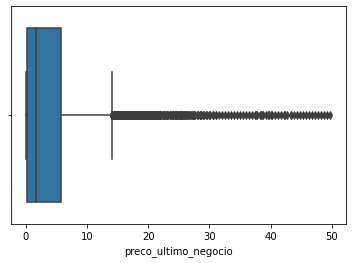

In [13]:
import seaborn as sns

sns.boxplot(x=sorted_e1["preco_ultimo_negocio"])

In [17]:
sorted2_e1 = empresa_1.sort_values(by=["volume_total_negociado"], ascending=True)

In [18]:
sorted2_e1["volume_total_negociado"].std()

6105593.487115127

In [25]:
sorted2_e1["volume_total_negociado"].mean()

710625.8090156578

In [28]:
sorted2_e1["volume_total_negociado"].median()

38973.0

<AxesSubplot:xlabel='volume_total_negociado'>

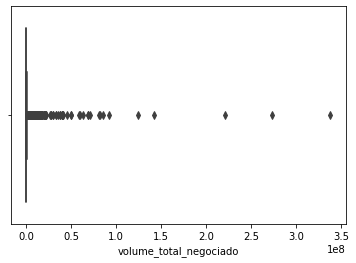

In [20]:
sns.boxplot(x=sorted2_e1["volume_total_negociado"])

In [30]:
sorted3_e1 = empresa_1.sort_values(by=["numero_negocios"], ascending=True)

In [31]:
sorted3_e1["numero_negocios"].std()

384.4783561749845

In [32]:
sorted3_e1["numero_negocios"].mean()

124.9536252119278

In [33]:
sorted3_e1["numero_negocios"].median()

13.0

<AxesSubplot:xlabel='numero_negocios'>

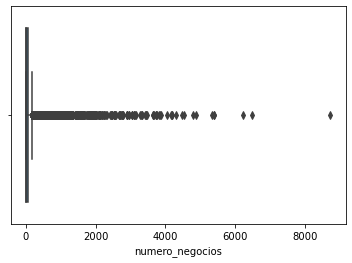

In [51]:
sns.boxplot(sorted3_e1["numero_negocios"])